# **Project - Recommendation Systems: Movie Recommendation System**

---------------
## **Context**
---------------

Online streaming platforms like **Netflix** have plenty of movies in their repository and if we can build a **Recommendation System** to recommend **relevant movies** to users, based on their **historical interactions**, this would **improve customer satisfaction** and hence, it will also improve the revenue of the platform.

-----------------
## **Objective**
-----------------

In this project we will be building various recommendation systems:
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

we are going to use the **ratings** dataset.

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes:
- userId
- movieId
- rating
- timestamp

## **Importing the necessary libraries and overview of the dataset**

In [5]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [ ]:
# Import the dataset
rating = pd.read_csv("ratings.csv")

Let's check the **info** of the data

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **100,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [ ]:
# Dropping timestamp column
rating = rating.drop(["timestamp"], axis = 1)

## **Exploring the dataset**
### **Print the top 5 rows of the dataset**

In [ ]:
# Printing the top 5 rows of the dataset
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### **Describe the distribution of ratings**



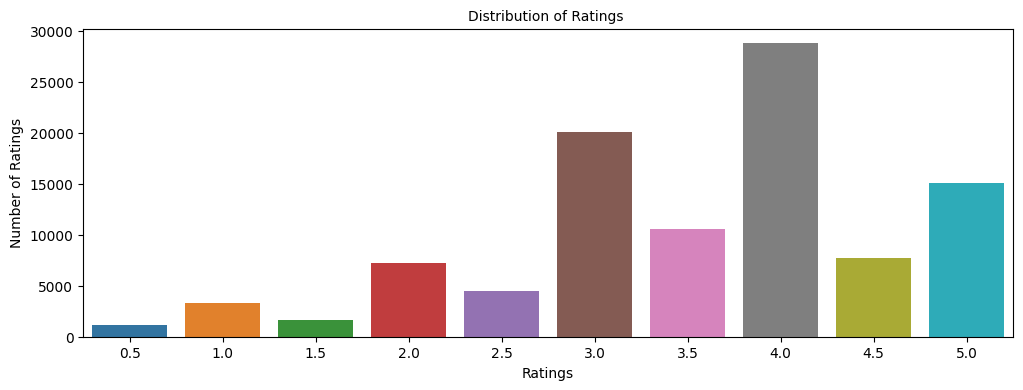

In [ ]:
plt.figure(figsize = (12, 4))
sns.countplot(data = rating, x = "rating")
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

- We can see that 4.0 stars rating has the most number of ratings, about 28000.
- 3.0 and 5.0 stars rating are second and third, while the rest has an ascending pattern, with the whole-number ratings are always more significant than their counterpart.

### **The total number of unique users and unique movies**


In [ ]:
# Finding number of unique users
rating["userId"].nunique()

671

- There are 671 unique users.

In [ ]:
# Finding number of unique movies
rating["movieId"].nunique()

9066

- There are 9066 unique movies.

### **Checking if there is a movie in which the same user interacted with it more than once**

In [ ]:
rating.groupby(["userId", "movieId"]).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [ ]:
rating.groupby(["userId", "movieId"]).count()["rating"].sum()

100004

- There isn't a movie where the same user interacted with it more than once.

### **Finding the most interacted movie in the dataset**

In [ ]:
rating["movieId"].mode()

0    356
Name: movieId, dtype: int64

- Movie with Id 356 has the most interacted movie in the dataset.

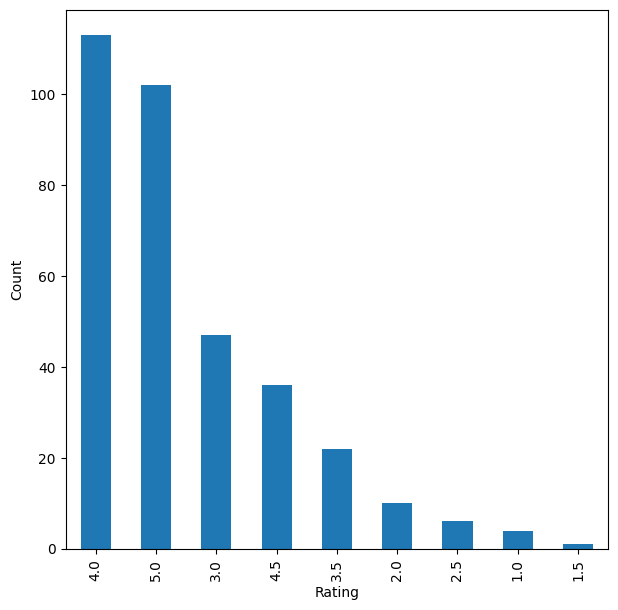

In [ ]:
# Plotting distributions of ratings for movieid 356
plt.figure(figsize = (7, 7))

rating[rating["movieId"] == 356]["rating"].value_counts().plot(kind = "bar")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

- About two thirds of movieId 356's rating are 4.0 and 5.0 ratings.
- The rest of the ratings makes up the remaining 1/3, with 1.5 being the lowest interacted rating.

### **Finding the user interacted the most with any movie in the dataset**

In [ ]:
rating["userId"].mode()

0    547
Name: userId, dtype: int64

- User with Id 547 interacted the most with any movie in the dataset.

### **Finding the distribution of the user-movie interactions in this dataset**

In [ ]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby("userId").count()["movieId"]
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

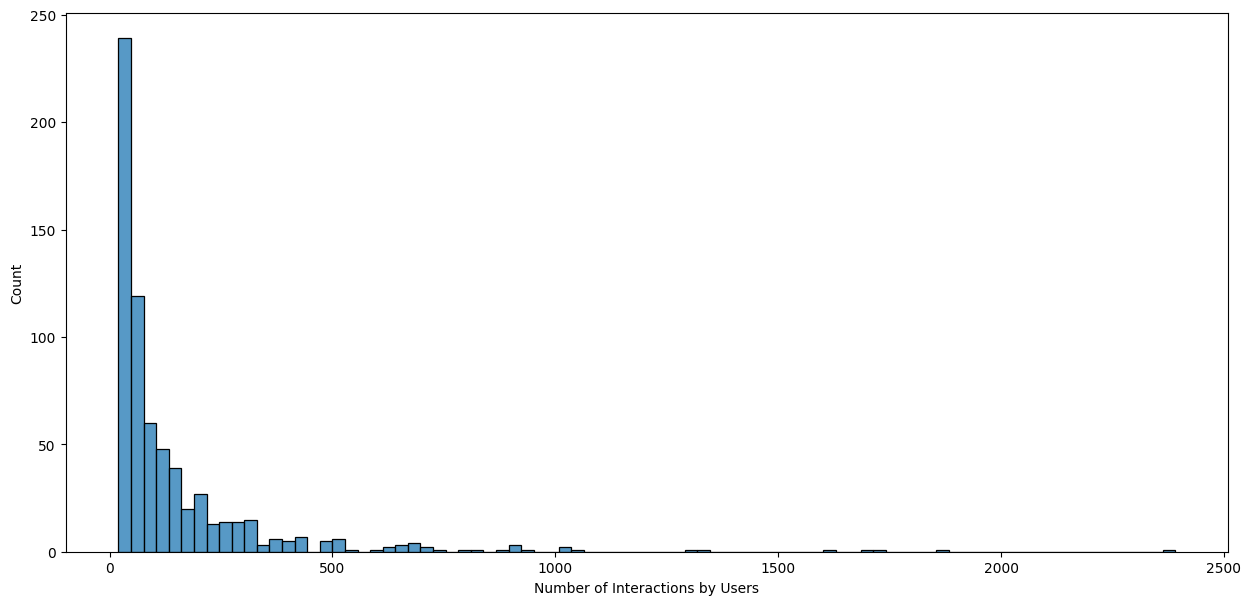

In [ ]:
# Plotting user-movie interactions distribution
plt.figure(figsize = (15, 7))

sns.histplot(data = rating, x = count_interactions)
plt.xlabel("Number of Interactions by Users")
plt.show()

- The histogram is right-skewed, the majority of users rated less than 500 movies.

#### As we have now explored the data, let's start building Recommendation systems

## **Create Rank-Based Recommendation System**

## **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [ ]:
# Calculating average ratings
average_rating = rating.groupby("movieId").mean()["rating"]

# Calculating the count of ratings
count_rating = rating.groupby("movieId").count()["rating"]

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({"avg_rating": average_rating, "rating_count": count_rating})

In [ ]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation.

In [ ]:
def top_n_movies(data, n, min_interaction = 100):
    #Finding movies with minimum number of interactions
    recommendations = data[data["rating_count"] >= min_interaction]

    #Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = "avg_rating", ascending = False)

    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_movies(final_rating, 5, 50))

[858, 318, 969, 913, 1221]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [ ]:
list(top_n_movies(final_rating, 5, 200))

[858, 318, 50, 527, 608]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

## **Model 2: User based Collaborative Filtering Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example -
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[["userId", "movieId", "rating"]], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [ ]:
# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options = {"name": "cosine", "user_based": True}, verbose = False)

# Train the algorithm on the trainset or fitting the model on train dataset
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### **Finding the RMSE for baseline user based collaborative filtering recommendation system**

- The RMSE is 0.9925 for baseline user based collaborative filtering recommendation system.

### **Predict rating for a user with userId = 4 and for movieId = 10 and movieId = 3**

Let's predict rating for a user with `userId = 4` and for `movieId = 10`

In [ ]:
algo_knn_user.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 10 is 3.62.

Let's predict the rating for the same `userId = 4` but for a movie which this user has not interacted before i.e. `movieId = 3`

In [ ]:
algo_knn_user.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 3 is 3.20.

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm.

### **Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    "k": [20, 30, 40],
    "min_k": [3, 6, 9],
    "sim_options": {
        "name": ["msd", "cosine", "pearson"],
        "user_based": [True]
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures = ["rmse", "mae"], cv = 3, n_jobs = -1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params["rmse"])

0.9664525758459459
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [ ]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.966304,0.967341,0.965713,0.966453,0.000673,1,0.744935,0.741419,0.741753,0.742702,0.001584,1,0.088900,0.006148,2.633398,0.036664,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.994612,0.996294,0.995149,0.995352,0.000701,14,0.770358,0.767377,0.768886,0.768874,0.001217,12,0.174466,0.014111,3.141166,0.403945,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,1.001071,1.000395,1.000171,1.000546,0.000382,22,0.780616,0.776316,0.775742,0.777558,0.002175,23,0.338059,0.123248,3.724617,0.350836,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'pearson', 'user_based': True}"
3,0.971140,0.970957,0.966376,0.969491,0.002204,3,0.748474,0.744170,0.743156,0.745267,0.002305,2,0.104345,0.025296,2.920326,0.233050,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
4,0.998083,0.998739,0.994400,0.997074,0.001910,15,0.772777,0.769076,0.769199,0.770351,0.001716,15,0.235164,0.081980,3.725729,0.138987,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.



In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options = {"name": "msd", "user_based": True}, k = 20, min = 3,verbose = False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9625


0.9625200448463395

- After the hyperparameter tuning, the RMSE of the model has slightly reduced from 0.964 to 0.963.

### **Predict rating for a user with userId = 4 and for movieId = 10 and movieId = 3 using tuned user based collaborative filtering**

Let's predict rating for a user with `userId = 4` and for `movieId = 10` with the optimized model

In [ ]:
similarity_algo_optimized_user.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 10 is 3.74.

Let's predict rating for the same `userId = 4` but for a movie which this user has not interacted before i.e. `movieId = 3`, by using the optimized model as shown below

In [ ]:
similarity_algo_optimized_user.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 3 is 3.72.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId = 4` based on the `msd` distance metric

In [ ]:
similarity_algo_optimized_user.get_neighbors(4, k = 5)

[665, 417, 647, 654, 260]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:
- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    # Creating an empty list to store the recommended movie ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = "userId", columns = "movieId", values = "rating")

    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for `userId = 4` with similarity based recommendation system**

In [ ]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_user)

### **Predict the top 5 movies for `userId = 4` with similarity based recommendation system**

In [ ]:
recommendations

[(53, 5), (183, 5), (301, 5), (309, 5), (559, 5)]

## **Model 3: Item based Collaborative Filtering Recommendation System**

In [ ]:
# Definfing similarity measure
sim_options = {
    "name": "cosine",
    "user_based": False
}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options = sim_options, verbose = False)

# Train the algorithm on the trainset or fitting the model on train dataset
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

### **Finding the RMSE for baseline item based collaborative filtering recommendation system**

- The RMSE for baseline item based collaborative filtering recommendation system is 1.0032.

Let's predict rating for a user with `userId = 4` and for `movieId = 10`

### **Predict rating for a user with userId = 4 and for movieId = 10 and movieId = 3**

In [ ]:
algo_knn_item.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 10 is 4.37.

Let's predict  the rating for the same `userId = 4` but for a movie which this user has not interacted before i.e. `movieId = 3`

In [ ]:
algo_knn_item.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 3 is 4.07.

### **Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    "k": [20, 30, 40],
    "min_k": [3, 6, 9],
    "sim_options": {
        "name": ["msd", "cosine", "pearson"],
        "user_based": [False]
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures = ["rmse", "mae"], cv = 3, n_jobs = -1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params["rmse"])

0.9407460175535595
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [ ]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.948569,0.952666,0.953803,0.951680,0.002248,7,0.732772,0.734602,0.735162,0.734178,0.001021,7,3.854873,0.368458,13.737819,0.451389,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.010522,1.013693,1.017809,1.014008,0.002983,25,0.788849,0.789563,0.793200,0.790538,0.001905,25,8.749319,2.293727,18.817497,2.504901,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.999471,1.004793,1.007174,1.003813,0.003220,24,0.776339,0.780595,0.783170,0.780035,0.002816,22,9.774779,0.069735,13.606451,1.262442,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'pearson', 'user_based': False}"
3,0.948922,0.952611,0.954057,0.951864,0.002162,8,0.733224,0.734731,0.735340,0.734432,0.000890,8,4.212201,0.819870,12.849487,0.259301,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
4,1.010944,1.013920,1.018085,1.014316,0.002929,26,0.789295,0.789812,0.793386,0.790831,0.001819,26,7.191504,0.927742,16.580954,1.538218,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [ ]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options= {"name": "msd", "user_based": False}, k = 40, min_k = 3, verbose = False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9433


0.9433184999641279

- After the hyperparamter tuning, the RMSE of the model has slightly reduced from 1.00 to 0.94.

### **Predict rating for an item with userId = 4 and for movieId = 10 and movieId = 3 using tuned item based collaborative filtering**

Let's predict rating for a user with `userId = 4` and for `movieId = 10` with the optimized model as shown below

In [ ]:
similarity_algo_optimized_item.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 4.26   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.255054787154994, details={'actual_k': 40, 'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 10 using item based collaborative filtering is 4.26.

Let's predict the rating for the same `userId = 4` but for a movie which this user has not interacted before i.e. `movieId = 3`, by using the optimized model

In [ ]:
similarity_algo_optimized_item.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.87   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.865175609312417, details={'actual_k': 40, 'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 10 using item based collaborative filtering is 3.87.

### **Identifying similar items to a given item (nearest neighbors)**
We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the `movieId = 3` based on the `msd` distance metric

In [ ]:
similarity_algo_optimized_item.get_neighbors(3, k = 5)

[31, 37, 42, 48, 73]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [ ]:
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

### **Predict the top 5 movies for userId = 4 with similarity based recommendation system**

In [ ]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3078, 5), (3116, 5)]

## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

### **Build a baseline matrix factorization recommendation system**

In [ ]:
# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9005


0.9004599188614656

### **Finding the RMSE for baseline SVD based collaborative filtering recommendation system**

- The RMSE for baseline SVD based collaborative filtering recommendation system is 0.90.

### **Predict rating for a user with userId = 4 and for movieId = 10 and movieId = 3**

Let's now predict rating for a user with `userId = 4` and for `movieId = 10`

In [ ]:
algo_svd.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 4.13   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.133220865717994, details={'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 10 is 3.88.

Let's predict the rating for the same `userId = 4` but for a movie which this user has not interacted before i.e. `movieId = 3`

In [ ]:
algo_svd.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.58   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.5810966990301583, details={'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 3 is 3.51.

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

### **Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system**

In [ ]:
# Set the parameter space to tune
param_grid = {
    "n_epochs": [10, 20, 30],
    "lr_all": [0.001, 0.005, 0.01],
    "reg_all": [0.2, 0.4, 0.6]
}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures = ["rmse", "mae"], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.8937127910547294
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.937125,0.945224,0.946961,0.943103,0.004287,25,0.735046,0.738084,0.741641,0.738257,0.002695,25,0.871038,0.024485,0.383797,0.023631,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.941577,0.950158,0.950997,0.947577,0.004257,26,0.740562,0.743229,0.746515,0.743435,0.002435,26,0.819097,0.021768,0.419177,0.030344,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.945726,0.955595,0.955756,0.952359,0.004691,27,0.745330,0.749009,0.751777,0.748705,0.002641,27,0.866734,0.030912,0.429049,0.043346,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.901590,0.907705,0.909881,0.906392,0.003510,10,0.700905,0.700921,0.704842,0.702223,0.001852,9,1.103754,0.284817,0.678429,0.243613,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.908431,0.915830,0.916761,0.913674,0.003727,15,0.708151,0.709435,0.712475,0.710020,0.001813,15,1.430505,0.066945,0.639144,0.183606,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8956


0.8955841958229712

### **Predict rating for a user with userId = 4 and for movieId = 10 and movieId = 3 using SVD based collaborative filtering**

Let's predict rating for an user with `userId = 4` and for `movieId = 10` with the optimized model

In [ ]:
svd_algo_optimized.predict(4, 10, r_ui = 4, verbose = True)

user: 4          item: 10         r_ui = 4.00   est = 3.98   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.983407438500722, details={'was_impossible': False})

- The predicted rating for a user with userId = 4 and for movieId = 10 using SVD based collaboratibe filtering is 3.99.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [ ]:
svd_algo_optimized.predict(4, 3, verbose = True)

user: 4          item: 3          r_ui = None   est = 3.63   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6342387896289217, details={'was_impossible': False})

### **Predict the top 5 movies for userId = 4 with SVD based recommendation system**

In [ ]:
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(116, 4.999403641631836),
 (3310, 4.983739341192889),
 (1948, 4.954596584559298),
 (1192, 4.953615149574188),
 (926, 4.943031896816885)]

### **Predicting ratings for already interacted movies**

Below we are comparing the rating predictions of users for those movies which has been already watched by a user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [ ]:
def predict_already_interacted_ratings(data, user_id, algo):

    # Creating an empty list to store the recommended movie ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = "userId", columns = "movieId", values = "rating")

    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()

    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]

        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return pd.DataFrame(recommendations, columns=["movieId", "actual_rating", "predicted_rating"]) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId = 7`

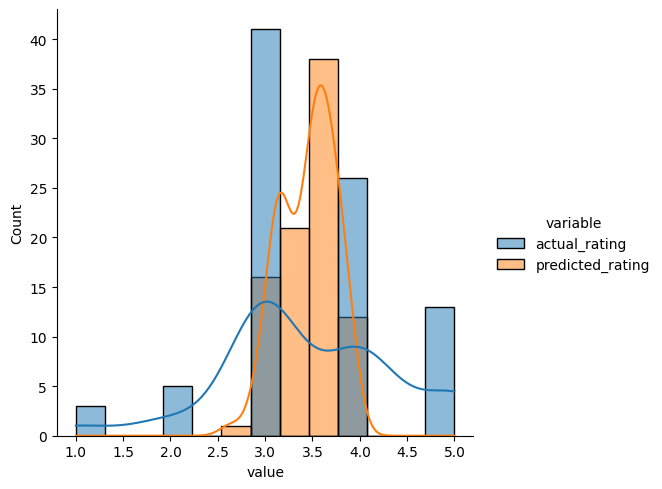

In [ ]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars = "movieId", value_vars = ["actual_rating", "predicted_rating"])
sns.displot(data = df, x = "value", hue = "variable", kde = True)

- The distribution of predicted_rating has similar peaks as actual_rating. Most actual values are between 3.0 and 4.0 and they are discreet; but for the predicted values, they can be continuous.
- Overall, the predictions looks quite good except for value 5.0, which doesn't have a prediction for at all.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId = 7`

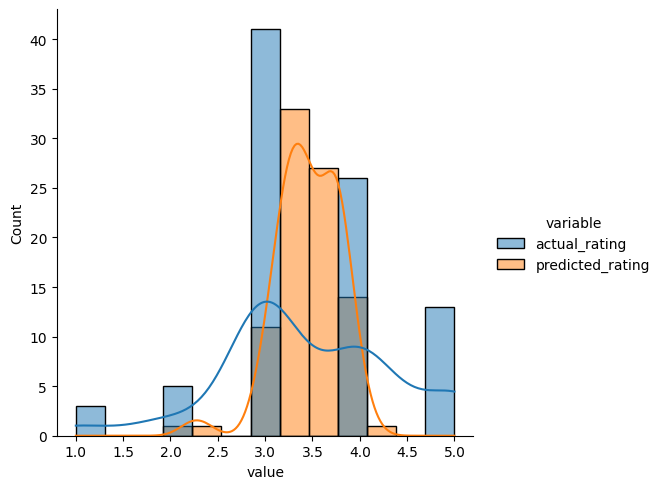

In [ ]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars = "movieId", value_vars = ["actual_rating", "predicted_rating"])
sns.displot(data = df, x = "value", hue = "variable", kde = True)

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[["userId", "movieId", "rating"]], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

## **Precision and Recall @ k**

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant movies, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

### **Compute the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values**

In [ ]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
# A basic cross-validation iterator.
kf = KFold(n_splits = 5)

# Make list of k values
K = [5, 10]

# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user, algo_knn_item, similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print("> k = {}, model = {}".format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose = False)
            precisions, recalls = precision_recall_at_k(predictions, k = k, threshold = 3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))

        print("-----> Precision: ", round(sum(p) / len(p), 3))
        print("-----> Recall: ", round(sum(r) / len(r), 3))

> k = 5, model = KNNBasic
-----> Precision:  0.77
-----> Recall:  0.417
> k = 5, model = KNNBasic
-----> Precision:  0.769
-----> Recall:  0.414
> k = 5, model = KNNBasic
-----> Precision:  0.61
-----> Recall:  0.326
> k = 5, model = KNNBasic
-----> Precision:  0.681
-----> Recall:  0.355
> k = 5, model = SVD
-----> Precision:  0.753
-----> Recall:  0.384
> k = 5, model = SVD
-----> Precision:  0.75
-----> Recall:  0.385
> k = 10, model = KNNBasic
-----> Precision:  0.75
-----> Recall:  0.55
> k = 10, model = KNNBasic
-----> Precision:  0.753
-----> Recall:  0.55
> k = 10, model = KNNBasic
-----> Precision:  0.598
-----> Recall:  0.477
> k = 10, model = KNNBasic
-----> Precision:  0.66
-----> Recall:  0.505
> k = 10, model = SVD
-----> Precision:  0.739
-----> Recall:  0.524
> k = 10, model = SVD
-----> Precision:  0.73
-----> Recall:  0.523


- The user-user based model has better precision and recall (0.768 and 0.411) than the item-item based model (0.608 and 0.324). In term of RMSE, there are not too different (0.9625 for user-user and 1.0032 for item-item).
- The tuned user-user based model also has better precision and recall (0.768 and 0.416) than the item-item based model (0.677 and 0.354). In term of RMSE, the tuned user-user model has the same RMSE before tuned (0.9625), but the tuned item-item model reduces from 1.0032 to 0.9433.
- While the collaborative filtering models use user-item ratings data to determine similarities and make predictions, the matrix factorization model is a personalized model based on past interactions of one user to make prediction. Collaborative filterings use KNN to search for similar neighbors while matrix factorization uses SVD to decompose the user-item matrix. The precision and recall for user-user based model is better than the matrix factorization model's. However, the matirx factorization model has better RMSE, 0.8953 compared to 0.9433 of the item-item based model.
- The matrix factorization model barely improved after tuned (RMSE from 0.9040 to 0.8953). Its low RMSE can be explained by its assumption of both users and items are present in low dimensional matrices after SVD, meaning it already accounts for latent factors.

### **Conclusions**

In this case study, we saw three different ways of building recommendation systems:
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.